# Visualising Multiple Survey Properties Maps

<img align="left" src = ../figs/logos/logo-IJCLab_v1.png height=40, style="padding: 10px"> 
<b>Correlations of Survey Properties Maps </b> <br>
Last verified to run on 2022-09-04 with LSST Science Pipelines release w_2022_22 <br>
Contact authors: Sylvie Dagoret-Campagne (DP0 Delegate) <br>
Target audience: DP0 delegates member <br>

## 1.Package Imports

In [1]:
# general python packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval, LinearStretch, ImageNormalize

# packages for working with sparse healpix maps
import healsparse as hsp
import skyproj

# LSST packages
from lsst.daf.butler import Butler
import lsst.geom as geom

# allow interactive plots
#%matplotlib widget
%matplotlib inline

# default plot style is accessible
plt.style.use('tableau-colorblind10')

## 2. Access Survey Property Maps from Butler

Survey property maps are created as part of the LSST Science Pipelines.
They take the form of sparse HEALPix maps, where the survey property at each spatial pixel is identified by a pixel number/pixel value pair.

Start by creating an instance of the Butler and using it to access these maps for DP0.

In [2]:
config = 'dp02'
collections = '2.2i/runs/DP0.2'
butler = Butler(config, collections=collections)
registry=butler.registry

Determine which property maps are available for the survey.

> **Notice:** The following cell may produce a warning about the 'ScarletModelData' storage class, which is safe to ignore.

## Queries

### Query Datasets Types

In [3]:
# Display the available dataset types
#for d in sorted(registry.queryDatasetTypes()): print(d.name,".....\t",d.nameAndComponent)

### Query Filtered Datasets Types

In [4]:
for dtype in sorted(butler.registry.queryDatasetTypes(expression="*consolidated_map*")):
    print(dtype.name)

deepCoadd_dcr_ddec_consolidated_map_weighted_mean
deepCoadd_dcr_dra_consolidated_map_weighted_mean
deepCoadd_dcr_e1_consolidated_map_weighted_mean
deepCoadd_dcr_e2_consolidated_map_weighted_mean
deepCoadd_exposure_time_consolidated_map_sum
deepCoadd_psf_e1_consolidated_map_weighted_mean
deepCoadd_psf_e2_consolidated_map_weighted_mean
deepCoadd_psf_maglim_consolidated_map_weighted_mean
deepCoadd_psf_size_consolidated_map_weighted_mean
deepCoadd_sky_background_consolidated_map_weighted_mean
deepCoadd_sky_noise_consolidated_map_weighted_mean


Each of these products represents a healsparse map containing the value of an individual survey property.

The meaning of these types is:

* `deepCoadd_dcr_ddec_consolidated_map_weighted_mean`: Average effect of differential chromatic refraction (DCR) in declination direction
* `deepCoadd_dcr_dra_consolidated_map_weighted_mean`: Average effect of differential chromatic refraction (DCR) in right ascension direction
* `deepCoadd_dcr_e1_consolidated_map_weighted_mean`: Average effect of differential chromatic refraction (DCR) on psf e1
* `deepCoadd_dcr_e2_consolidated_map_weighted_mean`: Average effect of differential chromatic refraction (DCR) on psf e2
* `deepCoadd_exposure_time_consolidated_map_sum`: Total exposure time (seconds)
* `deepCoadd_psf_e1_consolidated_map_weighted_mean`: Weighted mean of psf e1 of images input to coadd
* `deepCoadd_psf_e2_consolidated_map_weighted_mean`: Weighted mean of psf e2 of images input to coadd
* `deepCoadd_psf_maglim_consolidated_map_weighted_mean`: PSF Flux 5-sigma magnitude limit (AB)
* `deepCoadd_psf_size_consolidated_map_weighted_mean`: Weighted mean of psf size of images input to coadd (pixels)
* `deepCoadd_sky_background_consolidated_map_weighted_mean`: Weighted mean of sky background of images input to coadd (ADU)
* `deepCoadd_sky_noise_consolidated_map_weighted_mean`: Weighted mean of sky noise of images input to coadd (ADU)


Note that the DCR maps are proportionality maps; that is, the expected effect will be proportional to the value in the map with an arbitrary/empirically derived constant of proportionality.

Read a map by specifying the map name and a band.

## Start

In [5]:
# No consolidated map
all_map_names = []
for dtype in sorted(butler.registry.queryDatasetTypes(expression="*map*")):
    if "deepCoadd" in dtype.name and "consolidated_map" in  dtype.name :
        all_map_names.append(dtype.name)

In [6]:
all_map_names

['deepCoadd_dcr_ddec_consolidated_map_weighted_mean',
 'deepCoadd_dcr_dra_consolidated_map_weighted_mean',
 'deepCoadd_dcr_e1_consolidated_map_weighted_mean',
 'deepCoadd_dcr_e2_consolidated_map_weighted_mean',
 'deepCoadd_exposure_time_consolidated_map_sum',
 'deepCoadd_psf_e1_consolidated_map_weighted_mean',
 'deepCoadd_psf_e2_consolidated_map_weighted_mean',
 'deepCoadd_psf_maglim_consolidated_map_weighted_mean',
 'deepCoadd_psf_size_consolidated_map_weighted_mean',
 'deepCoadd_sky_background_consolidated_map_weighted_mean',
 'deepCoadd_sky_noise_consolidated_map_weighted_mean']

In [7]:
index=10

In [8]:
selected_map_name = all_map_names[index]

In [9]:
all_hspmaps = []
all_bands = ['u','g','r','i','z','y']
for band in all_bands:
    hspmap = butler.get(selected_map_name, band=band)
    all_hspmaps.append(hspmap)

In [10]:
len(all_hspmaps)

6

## 3. Manipulating Survey Property Maps

The survey property maps are provided as HealSparseMap objects.

We provide a few very brief examples here.

To conserve memory, HealSparse uses a dual-map approach, where a low-resolution full-sky “coverage map” is combined with a high resolution map containing the pixel data where it is available. It is easy to find the resolution of these maps.

In [11]:
print(hspmap)

HealSparseMap: nside_coverage = 32, nside_sparse = 32768, float64


Each pixel of the healsparse map corresponds to a small region of the sky.
The value of the map corresponds to the value of the survey property at that location.

To access the survey property value at a specific location or set of locations, query for the map value using the `get_values_pos` functionality.

In [12]:
print(hspmap.get_values_pos(60, -37))

140.61845423050724


Query for the map value at an array of locations.

In [13]:
ra = np.linspace(59.5, 60.5, 5)
print('RA: ', ra)
dec = np.linspace(-37.5, -36.5, 5)
print('Dec: ', dec)
for d in dec:
    print(hspmap.get_values_pos(ra, d))
del ra, dec

RA:  [59.5  59.75 60.   60.25 60.5 ]
Dec:  [-37.5  -37.25 -37.   -36.75 -36.5 ]
[139.39687866 139.81982773 140.48903252 140.25218937 139.87317197]
[139.94214249 139.59353416 139.59613173 140.12707406 139.95292319]
[140.67064852 139.77548001 140.61845423 139.5836158  140.29837496]
[140.93895258 140.29186269 141.06606868 140.53391857 141.47864302]
[140.45830938 140.73880666 140.38038276 140.57181259 140.4423481 ]


If you ask for the value of the map outside of the region where it is defined, you will get a sentinel value.

In [14]:
print(hspmap.get_values_pos(180, 0))

-1.6375e+30


## 4. Visualizing Survey Property Maps

Now that we know how to access the values of the healsparse map, we can put together our own simple visualization by creating a grid of RA, Dec values and asking for the map values.
We can then plot these values with matplotlib.
Note that if you pan or zoom, the map does not update in resolution or coverage area.

In [15]:
ix=0
iy=0
for idx in range(6):
    iy=idx//3
    ix=idx-iy*3
   
   
    print("ix",ix,'iy',iy)

ix 0 iy 0
ix 1 iy 0
ix 2 iy 0
ix 0 iy 1
ix 1 iy 1
ix 2 iy 1


In [16]:
def PlotSurveyPropertyMaps(maps,filters,title):

    ra = np.linspace(59.5, 60.5, 100)
    dec = np.linspace(-37.5, -36.5, 100)
    x, y = np.meshgrid(ra, dec)
    
    
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    
    idx=0
    ix=0
    iy=0
    
    for themap in maps:
   
        iy=idx//3
        ix=idx-iy*3
    
        print("idx",idx,"ix",ix,'iy',iy, "filter = ",filters[idx])
        
        values = maps[idx].get_values_pos(x, y)

        
        
        ax[iy,ix].pcolormesh(x, y, values) 

        ax[iy,ix].set_xlabel("Right Ascension (deg)")
        ax[iy,ix].set_ylabel("Declination (deg)")
        label=" band " + filters[idx]
        ax[iy,ix].set_title(label)
        ax[iy,ix].axis('tight')
        #ax[ix,iy].colorbar(label=title)

        del values
        idx+=1

    plt.tight_layout()
    plt.suptitle(title,y=1.002)
    figname = title+".png"
    plt.savefig(figname)
    plt.show()
    
    del fig, ra, dec, x, y
    del ax

idx 0 ix 0 iy 0 filter =  u
idx 1 ix 1 iy 0 filter =  g
idx 2 ix 2 iy 0 filter =  r
idx 3 ix 0 iy 1 filter =  i
idx 4 ix 1 iy 1 filter =  z
idx 5 ix 2 iy 1 filter =  y


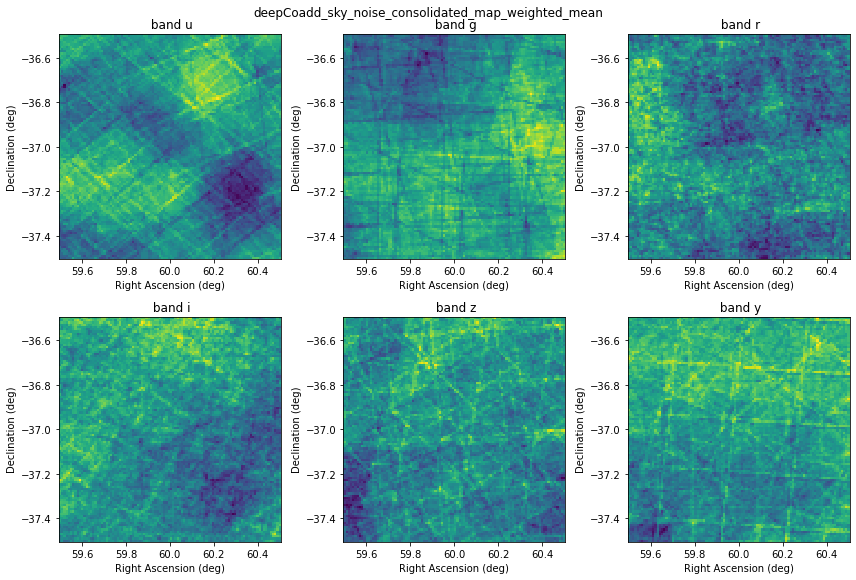

In [17]:
PlotSurveyPropertyMaps(all_hspmaps ,all_bands,selected_map_name)

The `skyproj` package provides much more advanced plotting capabilities.
Here we will demonstrate some basic use-cases for dealing with survey property maps.

The use of `McBrydeSkyproj` with `lon_0=65.0` creates a visualization using the McBryde-Thomas Flat Polar Quartic projection, centered at 65 deg longitude, which is appropriate for the DP0.2 footprint.

In [18]:
filt_idx = 5
the_hspmap = all_hspmaps[filt_idx] 

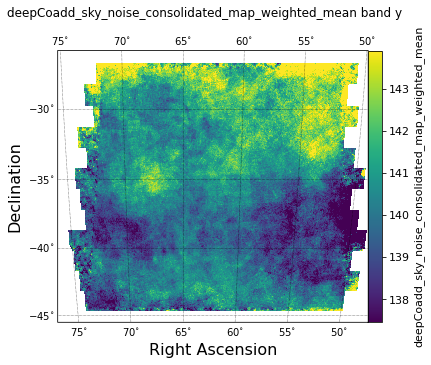

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))
sp = skyproj.McBrydeSkyproj(ax=ax, lon_0=65.0)
sp.draw_hspmap(the_hspmap)
sp.draw_colorbar(label=selected_map_name)
thetitle = selected_map_name + " band " + all_bands[filt_idx]
plt.suptitle(thetitle,y=1.001)
plt.show()

del fig, ax, sp

# Pixel values

In [20]:
the_hspmap.nside_sparse

32768

In [21]:
the_hspmap.nside_coverage

32

In [22]:
the_hspmap.n_valid

107259162

In [23]:
valid_pixels_indices = the_hspmap.valid_pixels
print(valid_pixels_indices) # These are the indices of the HEALPixels with nside=1024 that have been observed

[8922725879 8922725883 8922725884 ... 9470880424 9470880425 9470880426]


In [24]:
len(valid_pixels_indices)

107259162

In [25]:
the_hspmap[valid_pixels_indices]

array([138.00129318, 137.15555951, 138.09978587, ..., 146.32973341,
       146.32973341, 145.81918317])